# Permutational variable importance for explaining models on the Titanic dataset

author: Witalis Domitrz <witekdomitrz@gmail.com>

# Appendix

## Preparation

### Install modules

### Download the data

In [1]:
!wget http://students.mimuw.edu.pl/~wd393711/iml/titanic.zip
!unzip -o titanic.zip
!rm titanic.zip

--2020-05-04 11:21:18--  http://students.mimuw.edu.pl/~wd393711/iml/titanic.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34877 (34K) [application/zip]
Saving to: ‘titanic.zip’

titanic.zip         100%[===================>]  34,06K  --.-KB/s    in 0,01s   

2020-05-04 11:21:18 (3,41 MB/s) - ‘titanic.zip’ saved [34877/34877]

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Prepare the data

In [4]:
import numpy as np
import pandas as pd

used_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']
X_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Y_columns = ['Survived']

def load_data(fn):
    return pd.read_csv(fn).set_index('PassengerId')

def to_array(data):
    return pd.get_dummies(data).astype(dtype='float32')

def data_preprocessing():
    global train, test
    train = load_data('./train.csv')
    test = load_data('./gender_submission.csv').join(load_data('./test.csv'))  

    train['is_train'] = True
    test['is_train'] = False
    data = pd.concat([train, test])

    # Replace missing values with mean
    data.fillna(data.mean(), inplace=True)

    # Split test and train
    train, test = data[data['is_train']], data[data['is_train'] == False]

    # No unused columns
    train, test = train[used_columns], test[used_columns]

    train, test = to_array(train), to_array(test)
data_preprocessing()


def split_to_x_y(data):
    return to_array(data[X_columns]), to_array(data[Y_columns])

def get_data():
    return split_to_x_y(train), split_to_x_y(test)

def unlabel_data(*sets):
    return ((part.values for part in subset) for subset in sets)

In [5]:
(train_x, train_y), (test_x, test_y) = get_data()

## 1.
For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [25]:
from xgboost import XGBClassifier

### Create a model

In [30]:
model1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1, gamma=0,
                       learning_rate=0.1, max_delta_step=0, max_depth=4,
                       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                       nthread=None, objective='binary:logistic', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=None, subsample=1, verbosity=1)
model1_name = "XGBClassifier"

### Train a model

In [31]:
model1.fit(train_x, train_y.values[::,0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=1)

### Check the first model accuracy

In [41]:
from sklearn.metrics import accuracy_score
def check_accuracy(model, xy=(test_x, test_y)):
    x, y = xy
    pred = model.predict(x)
    accuracy = accuracy_score(y, [round(value) for value in pred])
    return accuracy

In [42]:
print("model:", model1_name, "\taccuracy:", check_accuracy(model1))

model: XGBClassifier 	accuracy: 0.8827751196172249


## 2.
calculate permutational variable importance for the selected model,

### Use permutation_importance from scikit-learn

In [49]:
from sklearn.inspection import permutation_importance

### Plot as here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [101]:
import matplotlib.pyplot as plt
def plot_permutation_importance(model_name, model, xy=(test_x, test_y), **kwargs):
    x, y = xy

    result = permutation_importance(model, x, y, **kwargs)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(12,6))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=x.columns[sorted_idx])
    ax.set_title("Permutation Variable Importances for " + model_name)
    fig.tight_layout()
    plt.show()

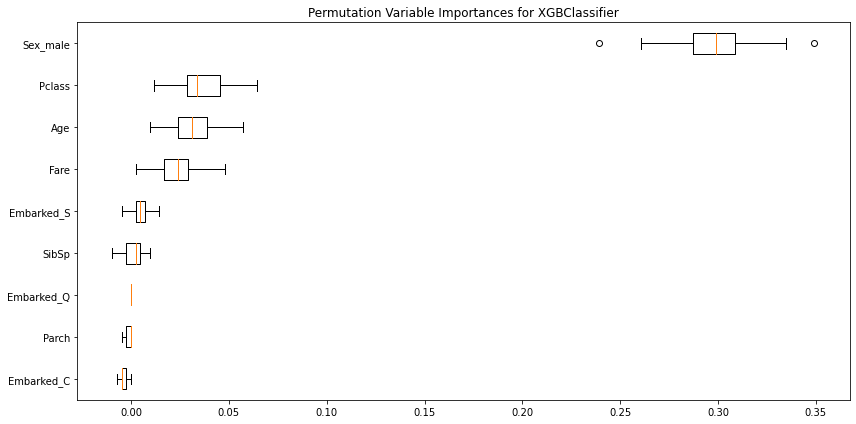

In [102]:
plot_permutation_importance(model1_name, model1, n_repeats=100)

## 3.
train three or more candidate models (different variables, different transformations, different model structures) and compare ranking of important features between these models. Are they similar or different?

### Use scikit-learn random forest classifier, decision tree classifier, linear classifier and k-nearest neighbours classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

### Create the models

In [86]:
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(), 
    "SGDClassifier": SGDClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier()}

### Fit the models

In [87]:
for model_name, model in models.items():
    print("Training", model_name)
    model.fit(train_x, train_y.values[::,0])

Training RandomForestClassifier
Training DecisionTreeClassifier
Training SGDClassifier
Training KNeighborsClassifier


### Check the models accuracy

In [88]:
from sklearn.metrics import accuracy_score
for model_name, model in models.items():
    test_pred = model.predict(test_x)
    test_accuracy1 = accuracy_score(test_y, [round(value) for value in test_pred])
    print("model:", model_name, "\taccuracy:", test_accuracy1)

model: RandomForestClassifier 	accuracy: 0.8229665071770335
model: DecisionTreeClassifier 	accuracy: 0.8038277511961722
model: SGDClassifier 	accuracy: 0.8253588516746412
model: KNeighborsClassifier 	accuracy: 0.6722488038277512


### Plot permutational variable importance for those models

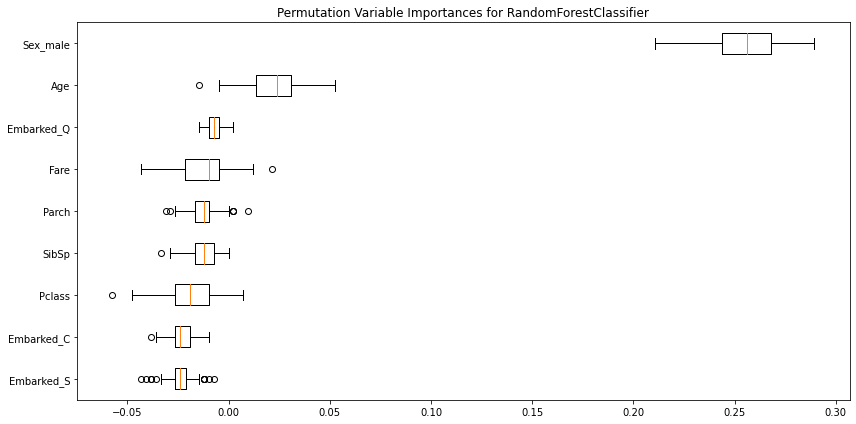

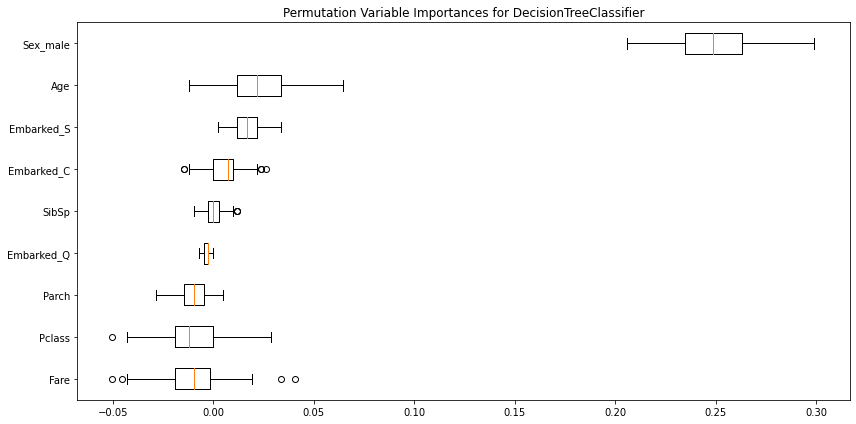

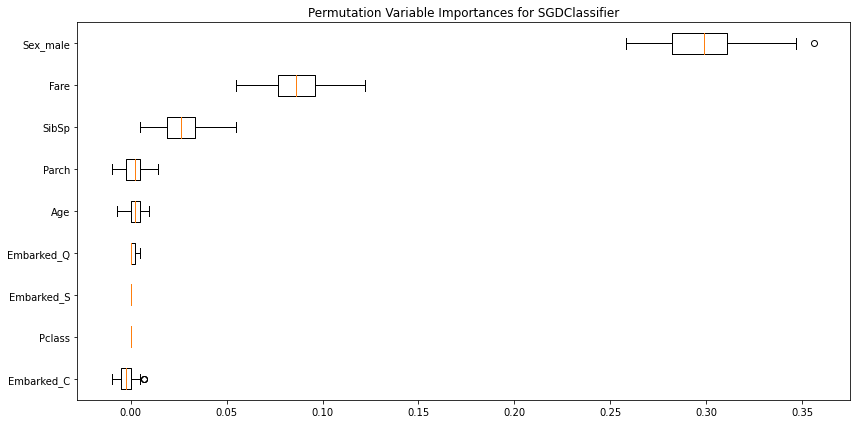

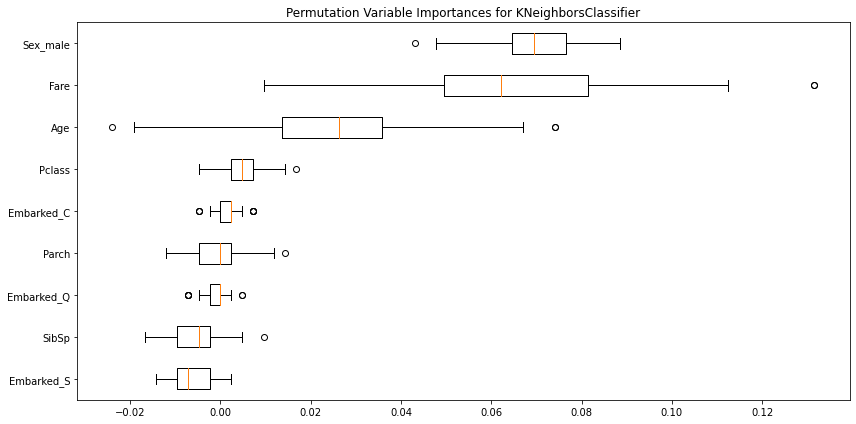

In [103]:
for model_name, model in models.items():
    plot_permutation_importance(model_name, model, n_repeats=100)

## 4.
Comment on the results for points (2) and (3)

2. permutational variable importance for the first model

    

3. permutational variable importance of other models

    